# Code for data preparation from different systems

-	**Kuramoto_simulation:**
	- Input: (number of nodes, coupling, number of timesteps)
	- Output: multivariate timeseries as pandas dataframe
-	**Perceptron_simulation:**
	- Input: ? (systemsize, learningrate and time)
	- Output: multivariate timeseries as pandas dataframe
-	**Human_connectome_data:**
	- Input: desired HCP data folder
	- Output: multivariate timeseries as pandas dataframe


# Kuramoto modelling

Import libraries

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import xgi
import pandas as pd
from numpy import random
import os
import itertools

Define functions

In [3]:
# === Traditional Kuramoto ===
def kuramoto_traditional(t, theta, omega, K, N):
    theta_i = theta[:, np.newaxis]
    theta_j = theta[np.newaxis, :]
    coupling_sum = np.sum(np.sin(theta_j - theta_i), axis=1)
    return omega + (K / N) * coupling_sum

def simulate_traditional_time_series(N, K, T=10, dt=0.01, n_sim=4):
    t_eval = np.arange(0, T, dt)
    r_all = []
    freq_dfs = []

    for _ in range(n_sim):
        omega = np.random.normal(0, 1, N)
        theta0 = np.random.uniform(0, 2*np.pi, N)

        sol = solve_ivp(kuramoto_traditional, [0, T], theta0, t_eval=t_eval, args=(omega, K, N))
        theta_ts = sol.y.T

        # Instantaneous frequencies
        freqs = np.gradient(theta_ts, axis=0) / dt

        # Store as DataFrame
        freq_df = pd.DataFrame(freqs, index=t_eval, columns=[f"osc_{i}" for i in range(N)])
        freq_dfs.append(freq_df)

        # Order parameter r(t)
        r = np.abs(np.mean(np.exp(1j * theta_ts), axis=1))
        r_all.append(r)

    r_all = np.array(r_all)
    return t_eval, r_all, freq_dfs 

def simulate_traditional_r_vs_K(N, K_vals, T=20, dt=0.01, n_sim=4):
    all_r = []

    for sim in range(n_sim):
        r_per_sim = []
        for K in K_vals:
            omega = np.random.normal(0, 1, N)
            theta = np.random.uniform(0, 2*np.pi, N)
            t_eval = np.arange(0, T, dt)
            sol = solve_ivp(kuramoto_traditional, [0, T], theta, t_eval=t_eval, args=(omega, K, N))
            r = np.abs(np.mean(np.exp(1j * sol.y.T), axis=1))
            r_per_sim.append(np.mean(r[int(0.5 * len(r)):]))

        all_r.append(r_per_sim)

    all_r = np.array(all_r)
    mean_r = np.mean(all_r, axis=0)
    return all_r, mean_r

# === XGI Kuramoto ===
def kuramoto_xgi(t, theta, omega, K2, K3, H, N):
    H_int = xgi.convert_labels_to_integers(H, "label")
    links = H_int.edges.filterby("size", 2).members()
    triangles = H_int.edges.filterby("size", 3).members()
    dtheta = np.zeros(N)
    r1 = np.zeros(N, dtype=complex)
    r2 = np.zeros(N, dtype=complex)
    for i, j in links:
        r1[i] += np.exp(1j * theta[j])
        r1[j] += np.exp(1j * theta[i])
    for i, j, k in triangles:
        r2[i] += np.exp(2j * theta[j] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[j])
        r2[j] += np.exp(2j * theta[i] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[i])
        r2[k] += np.exp(2j * theta[i] - 1j * theta[j]) + np.exp(2j * theta[j] - 1j * theta[i])
    for i in range(N):
        dtheta[i] = omega[i] + K2 * np.imag(r1[i] * np.exp(-1j * theta[i])) + K3 * np.imag(r2[i] * np.exp(-1j * theta[i]))
    return dtheta

def simulate_xgi_time_series(N, K, T=10, dt=0.01, n_sim=4):
    # generate fully connected hypergraph of N nodes
    H = xgi.Hypergraph()
    nodes = list(range(N))
    H.add_nodes_from(nodes)
    max_order = 3
    
    for k in range(1, max_order + 1):
        for edge in itertools.combinations(nodes, k):
            H.add_edge(edge)
    
    t_eval = np.arange(0, T, dt)
    K2 = K / N
    K3 = 0  # Adjust if high order included

    r_all = []
    freq_dfs = []

    for _ in range(n_sim):
        omega = np.random.normal(0, 1, N)
        theta0 = np.random.uniform(0, 2*np.pi, N)

        sol = solve_ivp(kuramoto_xgi, [0, T], theta0, t_eval=t_eval, args=(omega, K2, K3, H, N))
        theta_ts = sol.y.T

        # Instantaneous frequencies
        freqs = np.gradient(theta_ts, axis=0) / dt
        freq_df = pd.DataFrame(freqs, index=t_eval, columns=[f"osc_{i}" for i in range(N)])
        freq_dfs.append(freq_df)

        # Order parameter
        r = np.abs(np.mean(np.exp(1j * theta_ts), axis=1))
        r_all.append(r)

    r_all = np.array(r_all)
    return t_eval, r_all, freq_dfs

def simulate_xgi_r_vs_K(N, K_vals, T=20, dt=0.01, n_sim=4):
    all_r = []

    for sim in range(n_sim):
        r_per_sim = []
        for K in K_vals:
            H = xgi.Hypergraph()
            H.add_nodes_from(range(N))
            for i in range(N):
                for j in range(i + 1, N):
                    H.add_edge([i, j])

            K2 = K / N
            K3 = 0
            omega = np.random.normal(0, 1, N)
            theta = np.random.uniform(0, 2*np.pi, N)
            timesteps = int(T / dt)
            theta_time = np.zeros((timesteps, N))
            theta_curr = theta.copy()
            links = H.edges.filterby("size", 2).members()
            triangles = H.edges.filterby("size", 3).members()

            for t in range(timesteps):
                theta_time[t] = theta_curr
                r1 = np.zeros(N, dtype=complex)
                r2 = np.zeros(N, dtype=complex)
                for i, j in links:
                    r1[i] += np.exp(1j * theta_curr[j])
                    r1[j] += np.exp(1j * theta_curr[i])
                for i, j, k in triangles:
                    r2[i] += np.exp(2j * theta_curr[j] - 1j * theta_curr[k]) + np.exp(2j * theta_curr[k] - 1j * theta_curr[j])
                    r2[j] += np.exp(2j * theta_curr[i] - 1j * theta_curr[k]) + np.exp(2j * theta_curr[k] - 1j * theta_curr[i])
                    r2[k] += np.exp(2j * theta_curr[i] - 1j * theta_curr[j]) + np.exp(2j * theta_curr[j] - 1j * theta_curr[i])
                dtheta = omega + K2 * np.imag(r1 * np.exp(-1j * theta_curr)) + K3 * np.imag(r2 * np.exp(-1j * theta_curr))
                theta_curr += dtheta * dt

            r = np.abs(np.mean(np.exp(1j * theta_time), axis=1))
            r_per_sim.append(np.mean(r[int(0.5 * len(r)):]))

        all_r.append(r_per_sim)

    all_r = np.array(all_r)
    mean_r = np.mean(all_r, axis=0)
    return all_r, mean_r

Plot the characteristic coupling regions

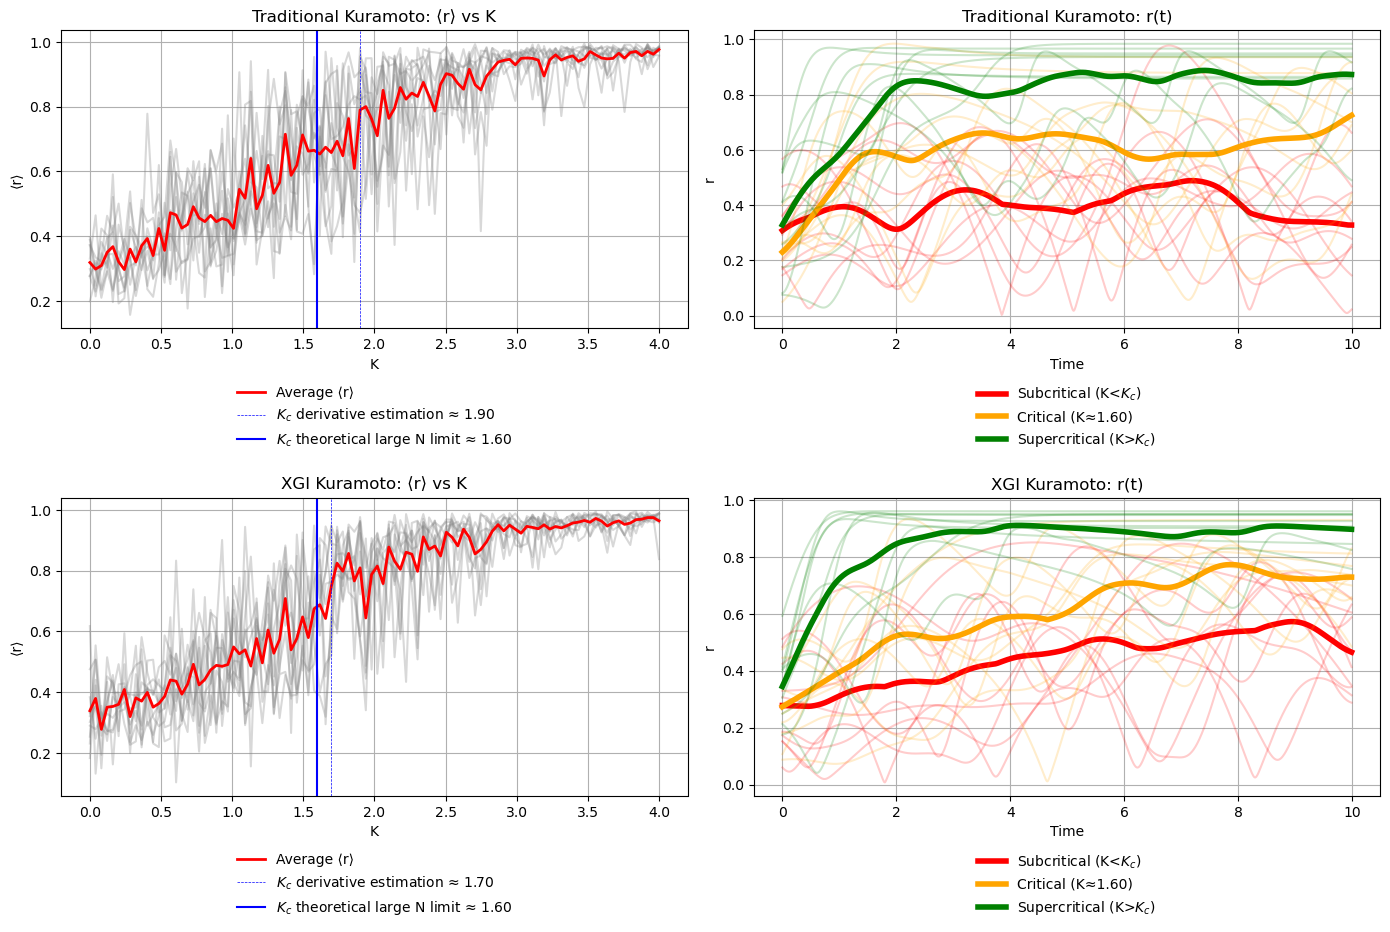

In [91]:
# === Plotting ===
n_simulations = 10
N = 8
T = 10
dt = 0.01
Kc_theoretical = 1.5958    # Theoretical estimation of critical coupling in the large N limit
K_vals = np.linspace(0, 4, 100)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Traditional: r vs K
all_r_trad, mean_r_trad = simulate_traditional_r_vs_K(N, K_vals, T, dt, n_simulations)
r_diff_trad = np.gradient(mean_r_trad, K_vals)
Kc_trad = K_vals[np.argmax(r_diff_trad)]

# Traditional: set the conditions for coupling regions
Ks_to_plot = [Kc_theoretical-1, Kc_theoretical, Kc_theoretical+1]
colors = ['r', 'orange', 'green']
labels = [f'Subcritical (K<$K_c$)', f'Critical (K≈{Kc_theoretical:.2f})', 'Supercritical (K>$K_c$)']

# Traditional: r vs K plot
for sim_r in all_r_trad:
    axs[0, 0].plot(K_vals, sim_r, color='gray', alpha=0.3)
axs[0, 0].plot(K_vals, mean_r_trad, color='red', linewidth=2, label='Average ⟨r⟩')
axs[0, 0].axvline(Kc_trad, color='blue', linestyle='--', linewidth=0.5, label=f'$K_c$ derivative estimation ≈ {Kc_trad:.2f}')
axs[0, 0].axvline(Kc_theoretical, color='blue', linestyle='-', label=f'$K_c$ theoretical large N limit ≈ {Kc_theoretical:.2f}')
axs[0, 0].set_title('Traditional Kuramoto: ⟨r⟩ vs K')
axs[0, 0].set_xlabel('K')
axs[0, 0].set_ylabel('⟨r⟩')
axs[0, 0].grid(True)
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# Traditional: Time series
for K, label, color in zip(Ks_to_plot, labels, colors):
    t, r_all, frequencies = simulate_traditional_time_series(N, K, T, dt, n_simulations)
    for run in r_all:
        axs[0, 1].plot(t, run, color=color, alpha=0.2)
    axs[0, 1].plot(t, r_all.mean(axis=0), color=color, linewidth=4, label=label)
axs[0, 1].set_title('Traditional Kuramoto: r(t)')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('r')
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# XGI: r vs K
all_r_xgi, mean_r_xgi = simulate_xgi_r_vs_K(N, K_vals, T, dt, n_simulations)
r_diff_xgi = np.gradient(mean_r_xgi, K_vals)
Kc_xgi = K_vals[np.argmax(r_diff_xgi)]

# XGI: set the conditions for coupling regions
Ks_to_plot = [Kc_theoretical-1, Kc_theoretical, Kc_theoretical+1]
colors = ['r', 'orange', 'green']
labels = ['Subcritical (K<$K_c$)', f'Critical (K≈{Kc_theoretical:.2f})', 'Supercritical (K>$K_c$)']

# XGI: r vs K plot
for sim_r in all_r_xgi:
    axs[1, 0].plot(K_vals, sim_r, color='gray', alpha=0.3)
axs[1, 0].plot(K_vals, mean_r_xgi, color='red', linewidth=2, label='Average ⟨r⟩')
axs[1, 0].axvline(Kc_xgi, color='blue', linestyle='--', linewidth=0.5, label=f'$K_c$ derivative estimation ≈ {Kc_xgi:.2f}')
axs[1, 0].axvline(Kc_theoretical, color='blue', linestyle='-', label=f'$K_c$ theoretical large N limit ≈ {Kc_theoretical:.2f}')
axs[1, 0].set_title('XGI Kuramoto: ⟨r⟩ vs K')
axs[1, 0].set_xlabel('K')
axs[1, 0].set_ylabel('⟨r⟩')
axs[1, 0].grid(True)
axs[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

# XGI: Time series
for K, label, color in zip(Ks_to_plot, labels, colors):
    t, r_all, frequencies = simulate_xgi_time_series(N, K, T, dt, n_simulations)
    for run in r_all:
        axs[1, 1].plot(t, run, color=color, alpha=0.2)
    axs[1, 1].plot(t, r_all.mean(axis=0), color=color, linewidth=4, label=label)
axs[1, 1].set_title('XGI Kuramoto: r(t)')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('r')
axs[1, 1].grid(True)
axs[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

Generate and store timeseries data

In [49]:
###################### SETTINGS ########################
# Choose model
model = "traditional"  # or "XGI"

# Parameters
N = 10       # Number of oscillators
K = 1.6     # Coupling strength
T = 10      # Total time
dt = 0.01   # Time step
n_sim = 3  # Number of simulations

# Set K2 = K / N for consistency with the standard Kuramoto model
K2 = K / N
K3 = 0  # Higher-order interactions

##################### DATA GENERATION ##################
# Run the simulation
if model == "traditional":
    t, r_vals, freqs = simulate_traditional_time_series(N, K, T, dt, n_sim)
elif model == "XGI":
    t, r_vals, freqs = simulate_xgi_time_series(N, K, T, dt, n_sim)
else:
    raise ValueError(f"Unknown model type: {model}")

# Ensure output directory exists
output_dir = f'Data/Kuramoto_data/{model}'
os.makedirs(output_dir, exist_ok=True)

# Save each frequency time series to CSV
for i in range(len(freqs)):
    freqs[i].to_csv(f'{output_dir}/kuramoto_frequencies_timeseries_N{N}_K{K}_T{T}_{i+1}.csv', index=False)

# Multilayer perceptron

Import libraries

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Define functions and classes

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def export_weight_history_as_dataframe(self):
    W1_array = np.array(self.W1_history)
    W2_array = np.array(self.W2_history)
    num_epochs = W1_array.shape[0]

    # Create column names
    W1_columns = [f'W1[{i}]' for i in range(W1_array.shape[1])]
    W2_columns = [f'W2[{i}]' for i in range(W2_array.shape[1])]

    # Combine all weights into a DataFrame
    all_weights = np.hstack((W1_array, W2_array))
    all_columns = W1_columns + W2_columns
    df = pd.DataFrame(all_weights, columns=all_columns)

    # Add epoch index
    df.insert(0, 'epoch', np.arange(num_epochs))

    return df

class MLP:
    # Paste this inside the MLP class
    def export_weight_history_as_dataframe(self):
        W1_array = np.array(self.W1_history)
        W2_array = np.array(self.W2_history)
        num_epochs = W1_array.shape[0]

        # Create column names
        W1_columns = [f'W1[{i}]' for i in range(W1_array.shape[1])]
        W2_columns = [f'W2[{i}]' for i in range(W2_array.shape[1])]

        # Combine weights
        all_weights = np.hstack((W1_array, W2_array))
        all_columns = W1_columns + W2_columns
        df = pd.DataFrame(all_weights, columns=all_columns)

        # Add epoch number as the first column
        df.insert(0, 'epoch', np.arange(num_epochs))

        return df

    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1, epochs=10000):
        assert 1 <= hidden_size <= 10, "Hidden layer size must be between 1 and 10."

        self.lr = learning_rate
        self.epochs = epochs

        # Weight initialization
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))


        # History tracking
        self.W1_history = []
        self.W2_history = []

        # Track loss
        self.loss_history = []

        # Track prediction
        self.prediction_history = []


    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)

        return self.a2

    def backward(self, X, y, output):
        error = y - output
        d_output = error * sigmoid_derivative(output)

        error_hidden = d_output.dot(self.W2.T)
        d_hidden = error_hidden * sigmoid_derivative(self.a1)

        # Gradient descent update
        self.W2 += self.a1.T.dot(d_output) * self.lr
        self.b2 += np.sum(d_output, axis=0, keepdims=True) * self.lr
        self.W1 += X.T.dot(d_hidden) * self.lr
        self.b1 += np.sum(d_hidden, axis=0, keepdims=True) * self.lr

    def train(self, X, y):
        for epoch in range(self.epochs):
            output = self.forward(X)
            self.backward(X, y, output)

            # Save weight history
            self.W1_history.append(self.W1.flatten().copy())
            self.W2_history.append(self.W2.flatten().copy())

            # Store predictions (raw sigmoid output)
            self.prediction_history.append(output.flatten().copy())

            # Compute and store loss
            loss = np.mean((y - output) ** 2)
            self.loss_history.append(loss)

    def predict(self, X):
        return (self.forward(X) > 0.5).astype(int)

    def plot_weight_evolution(self):
        W1_array = np.array(self.W1_history)
        W2_array = np.array(self.W2_history)

        plt.figure(figsize=(12, 4))

        # W1: input to hidden
        for i in range(W1_array.shape[1]):
            plt.plot(W1_array[:, i], label=f'W1[{i}]')

        # W2: hidden to output
        for j in range(W2_array.shape[1]):
            plt.plot(W2_array[:, j], linestyle='--', label=f'W2[{j}]')

        plt.title("Weight Evolution Over Time")
        plt.xlabel("Time")
        plt.ylabel("Weight Value")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_loss(self):
        plt.figure(figsize=(12, 4))
        plt.plot(self.loss_history)
        plt.title("Training Loss Over Epochs")
        plt.xlabel("Time")
        plt.ylabel("Mean Squared Error")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_prediction_heatmap(self):
        # Convert to (samples, epochs)
        pred_array = np.array(self.prediction_history).T  # shape: (4, epochs)

        plt.figure(figsize=(12, 4))
        sns.heatmap(pred_array, cmap="YlGnBu", cbar=True, xticklabels=200, yticklabels=[(0,0),(0,1),(1,0),(1,1)])
        plt.title("Prediction Evolution Over Time")
        plt.xlabel("Time")
        plt.ylabel("Sample Index")
        plt.tight_layout()
        plt.show()

Plot the characteristic behaviour for a single example of the model

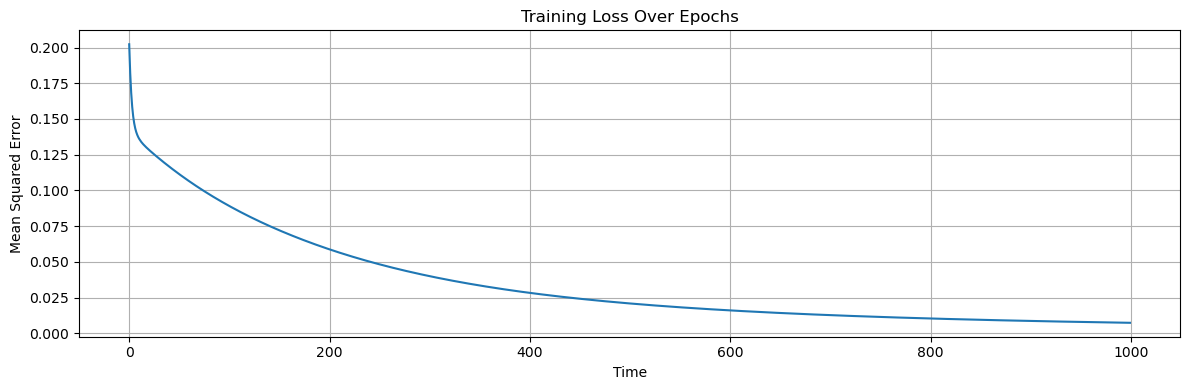

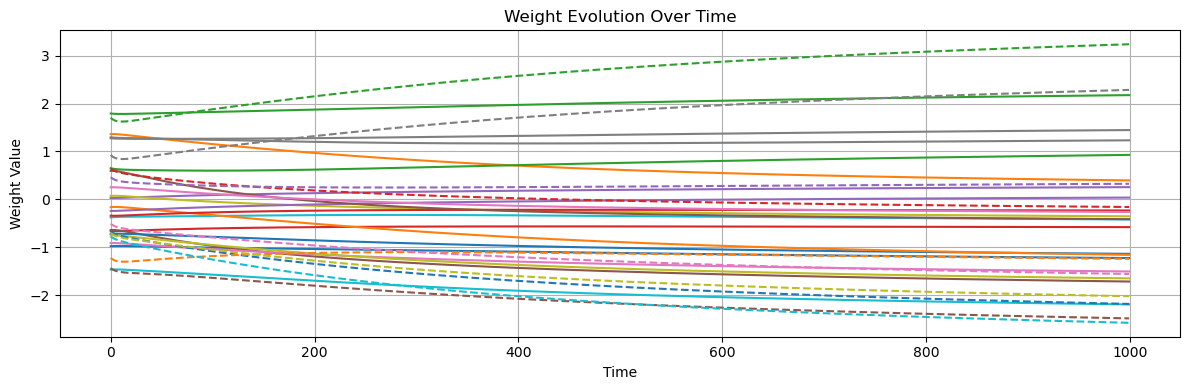

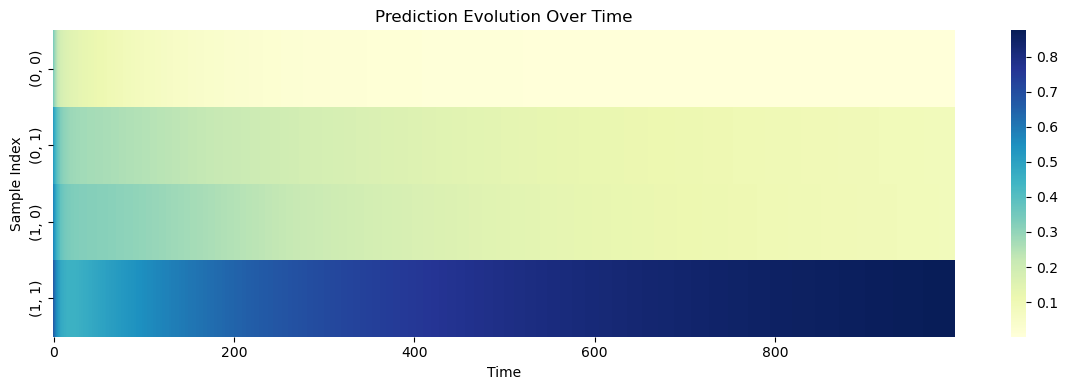

In [15]:
# AND gate
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [0], [0], [1]])

# Try 3 neurons, increase to up to 10
hidden_neurons = 10  # You can change this to 4, 5, ..., 10
mlp = MLP(input_size=2, hidden_size=hidden_neurons, output_size=1, learning_rate=0.15, epochs=1000)
mlp.train(X, y)

# Plot loss and weights
mlp.plot_loss()
mlp.plot_weight_evolution()
mlp.plot_prediction_heatmap()

Generate and store timeseries data

In [16]:
n_simulations = 3

for i in range(n_simulations):
    # AND gate
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y = np.array([[0], [0], [0], [1]])

    # Try 3 neurons, increase to up to 10
    hidden_neurons = 10  # You can change this to 4, 5, ..., 10
    mlp = MLP(input_size=2, hidden_size=hidden_neurons, output_size=1, learning_rate=0.15, epochs=1000)
    mlp.train(X, y)
    # mlp.plot_weight_evolution()   # If you want to plot the timeseries
    df_weights = mlp.export_weight_history_as_dataframe()
    df_weights.to_csv(f"Data\\Perceptron_data\\weight_evolution_N{hidden_neurons}_{i}.csv", index=False)  # Optional: export to CSV

# HCP data

# Lorentz-96 attractor

Import libraries

In [17]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Define functions

In [18]:
# Lorenz-96 model
def lorenz96(t, x, F):
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        dxdt[i] = (x[(i+1)%N] - x[i-2]) * x[i-1] - x[i] + F
    return dxdt

# Lyapunov exponent estimation using divergence of two trajectories
def lyapunov_exponent(F, N=40, T=10.0, dt=0.01, delta0=1e-5):
    t_eval = np.arange(0, T, dt)
    x0 = F * np.ones(N)
    x0[0] += 0.01
    x1 = x0 + np.random.normal(0, delta0, size=N)
    sol0 = solve_ivp(lambda t, x: lorenz96(t, x, F), [0, T], x0, t_eval=t_eval)
    sol1 = solve_ivp(lambda t, x: lorenz96(t, x, F), [0, T], x1, t_eval=t_eval)
    delta = np.linalg.norm(sol1.y - sol0.y, axis=0)
    log_delta = np.log(delta + 1e-12)
    slope, _ = np.polyfit(t_eval, log_delta, 1)
    return slope

# Helper to solve Lorenz-96 for plotting
def solve_lorenz96(F, N=40, T=10, points=2000):
    t_eval = np.linspace(0, T, points)
    x0 = F * np.ones(N)
    x0[0] += 0.01
    sol = solve_ivp(lambda t, x: lorenz96(t, x, F), [0, T], x0, t_eval=t_eval)
    return sol.t, sol.y

Plot characteristic forcing regions

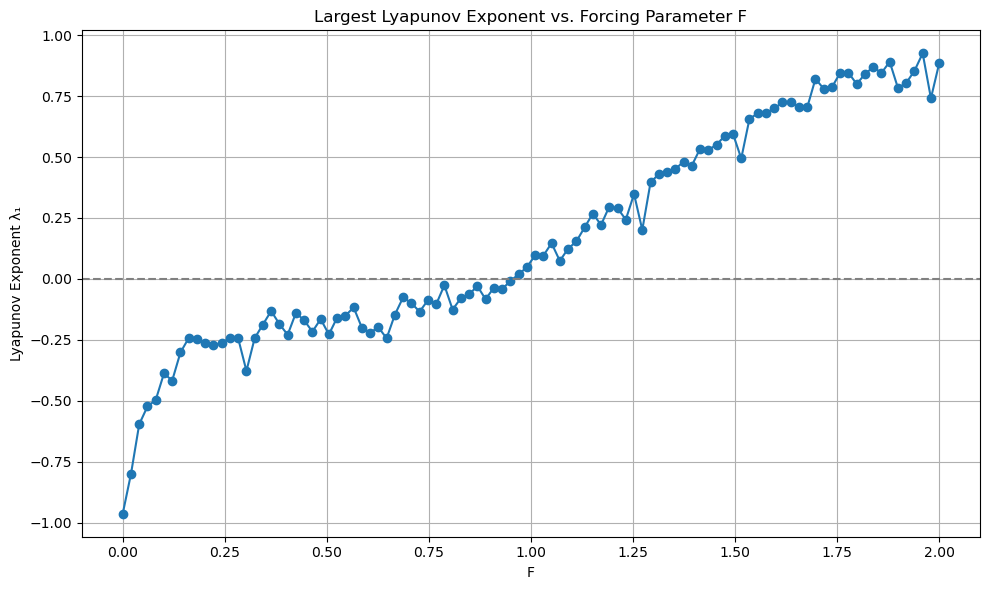

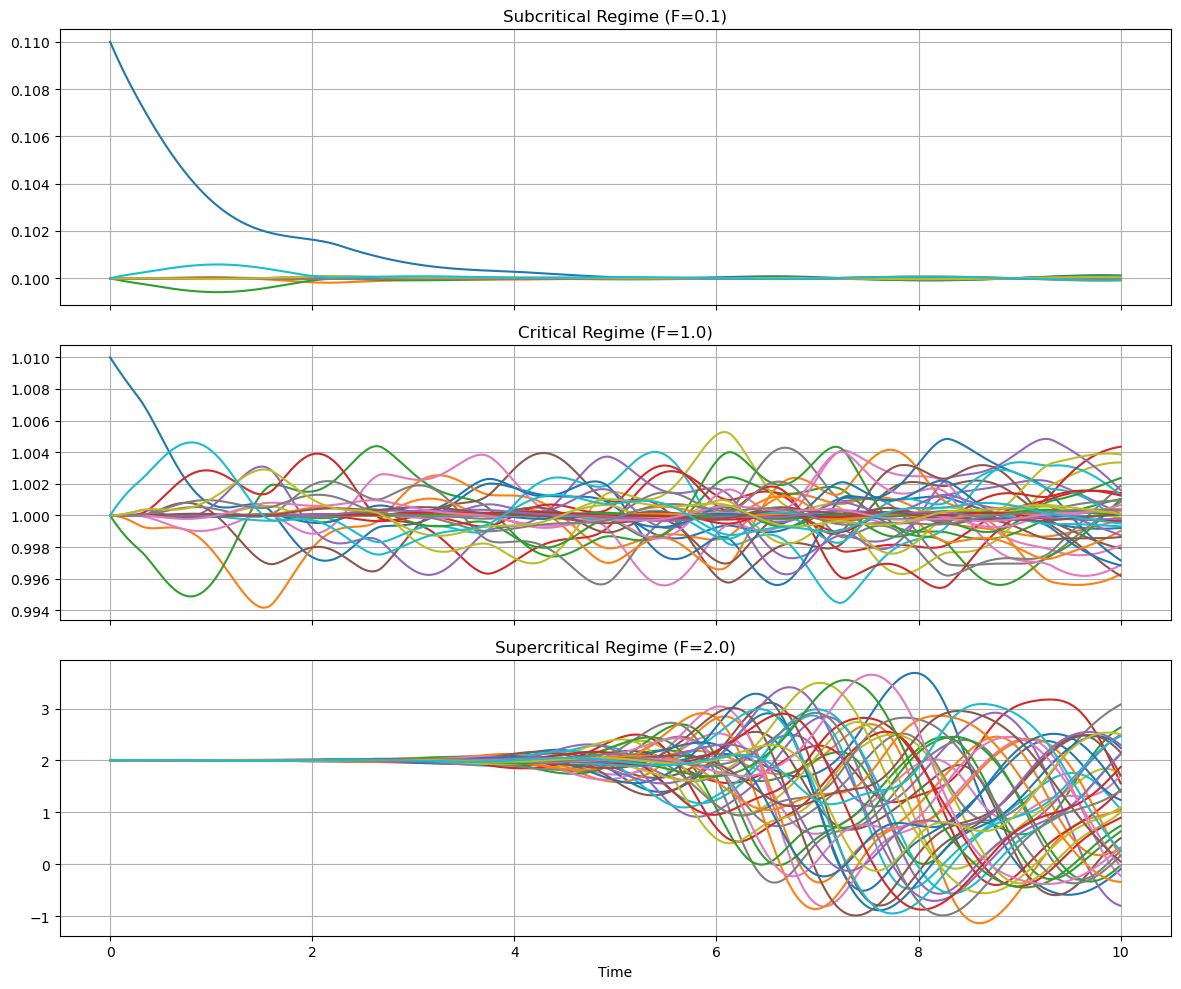

In [19]:
# Step 1: Calculate Lyapunov exponent vs. F
F_vals = np.linspace(0, 2, 100)
lyap_vals = [lyapunov_exponent(F) for F in F_vals]

# Step 2: Time series for selected regimes
F_sub = 0.1        # subcritical (λ < 0)
F_crit = 1.0       # critical (λ ≈ 0)
F_super = 2.0     # supercritical (λ > 0)

t_sub, y_sub = solve_lorenz96(F_sub)
t_crit, y_crit = solve_lorenz96(F_crit)
t_super, y_super = solve_lorenz96(F_super)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(F_vals, lyap_vals, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Largest Lyapunov Exponent vs. Forcing Parameter F")
plt.xlabel("F")
plt.ylabel("Lyapunov Exponent λ₁")
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Subcritical
for i in range(len(y_sub)):
    axs[0].plot(t_sub, y_sub[i], label=f'x[{i}]')
axs[0].set_title(f"Subcritical Regime (F={F_sub})")
axs[0].grid(True)

# Critical
for i in range(len(y_crit)):
    axs[1].plot(t_crit, y_crit[i], label=f'x[{i}]')
axs[1].set_title(f"Critical Regime (F={F_crit})")
axs[1].grid(True)

# Supercritical
for i in range(len(y_super)):
    axs[2].plot(t_super, y_super[i], label=f'x[{i}]')
axs[2].set_title(f"Supercritical Regime (F={F_super})")
axs[2].grid(True)

plt.xlabel("Time")
plt.tight_layout()
plt.show()

Generate and store timeseries data

In [21]:
n_simulations = 3
N_variables = 10
F_value = 2.0
time = 10
N_timesteps = 1000

for i in range(n_simulations):
    t_values, y_values = solve_lorenz96(F_value, N_variables, time, N_timesteps)

    df_crit = pd.DataFrame(y_values.T, columns=[f'x{i+1}' for i in range(y_values.shape[0])])
    df_crit.insert(0, 'time', t_values)
    df_crit.to_csv(f'Data\\Lorenz96_data\\timeseries_N{N_variables}_F{F_value}_{i}.csv', index=False)

# Voscek model

Import libraries

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Define functions

In [24]:
# Update function
def update(pos, angles, r):
    new_angles = np.copy(angles)

    for i in range(N):
        d = pos - pos[i]
        d = d - L * np.round(d / L)  # Periodic boundary conditions
        dist = np.linalg.norm(d, axis=1)
        neighbors = (dist < r)
        sin_sum = np.sum(np.sin(angles[neighbors]))
        cos_sum = np.sum(np.cos(angles[neighbors]))
        avg_angle = np.arctan2(sin_sum, cos_sum)
        new_angles[i] = avg_angle + eta * (np.random.rand() - 0.5) * 2 * np.pi

    pos[:, 0] += v * np.cos(new_angles) * dt
    pos[:, 1] += v * np.sin(new_angles) * dt
    pos %= L  # Periodic boundary wrap
    return pos, new_angles

# Order parameter
def compute_order_parameter(angles):
    total_velocity = np.sum(np.array([np.cos(angles), np.sin(angles)]), axis=1)
    return np.linalg.norm(total_velocity) / N

Plot characteristic interaction regions

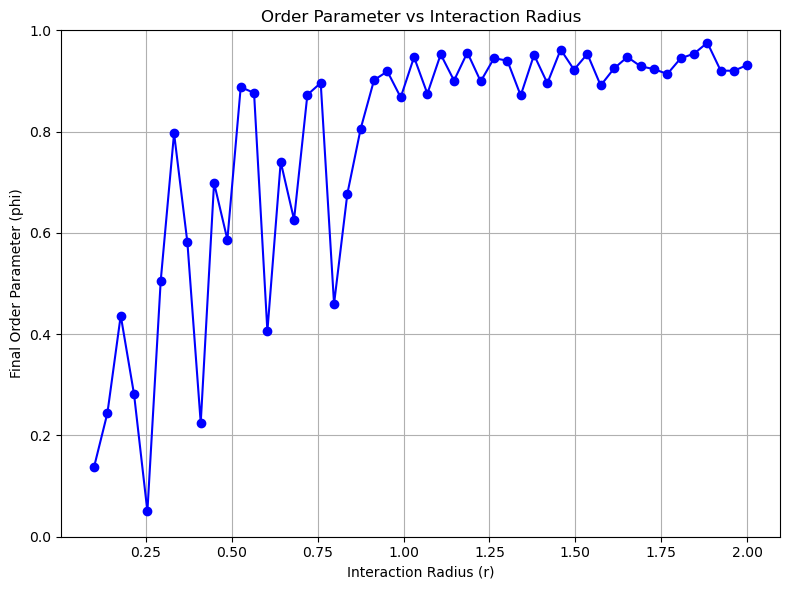

In [37]:
# Parameters
N = 10                # Number of particles
L = 4.0               # Size of the square box (periodic boundary)
eta = 0.2              # Noise amplitude (0 = no noise, 1 = full random)
v = 0.03               # Particle speed
dt = 1.0               # Time step
steps = 1000            # Number of simulation steps

# --- Part 1: Order parameter vs interaction radius ---
interaction_radii = np.linspace(0.1, 2.0, 50)
final_order_params = []

for r in interaction_radii:
    pos = np.random.rand(N, 2) * L
    angles = np.random.rand(N) * 2 * np.pi
    for step in range(steps):
        pos, angles = update(pos, angles, r)
    phi = compute_order_parameter(angles)
    final_order_params.append(phi)

# Plot: Order parameter vs interaction radius
plt.figure(figsize=(8, 6))
plt.plot(interaction_radii, final_order_params, color='b', marker='o')
plt.xlabel("Interaction Radius (r)")
plt.ylabel("Final Order Parameter (phi)")
plt.title("Order Parameter vs Interaction Radius")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

Generate and store timeseries data

In [38]:
# Parameters
N = 10                # Number of particles
L = 4.0               # Size of the square box (periodic boundary)
eta = 0.2              # Noise amplitude (0 = no noise, 1 = full random)
v = 0.03               # Particle speed
dt = 1.0               # Time step
steps = 1000            # Number of simulation steps

In [40]:
n_simulations = 3
save_dir = "Data\\Vicsek_data"
os.makedirs(save_dir, exist_ok=True)

r_values = {
    "Subcritical": 0.1,
    "Critical": 0.7,
    "Supercritical": 2.0
}

for k in range(n_simulations):
    for i, (label, r) in enumerate(r_values.items()):
        pos = np.random.rand(N, 2) * L
        angles = np.random.rand(N) * 2 * np.pi
        order_params = []
        angle_data = []

        for step in range(steps):
            pos, angles = update(pos, angles, r)
            phi = compute_order_parameter(angles)
            order_params.append(phi)
            row = list(angles) + [label, step]
            angle_data.append(row)

        # Save angle data to CSV
        columns = [f"angle_{j}" for j in range(N)] + ["regime", "step"]
        df = pd.DataFrame(angle_data, columns=columns)
        filename = f"{save_dir}/angles_N{N}_r{r}_{k}.csv"
        df.to_csv(filename, index=False)

Confirm data by plotting characteristic interaction regions

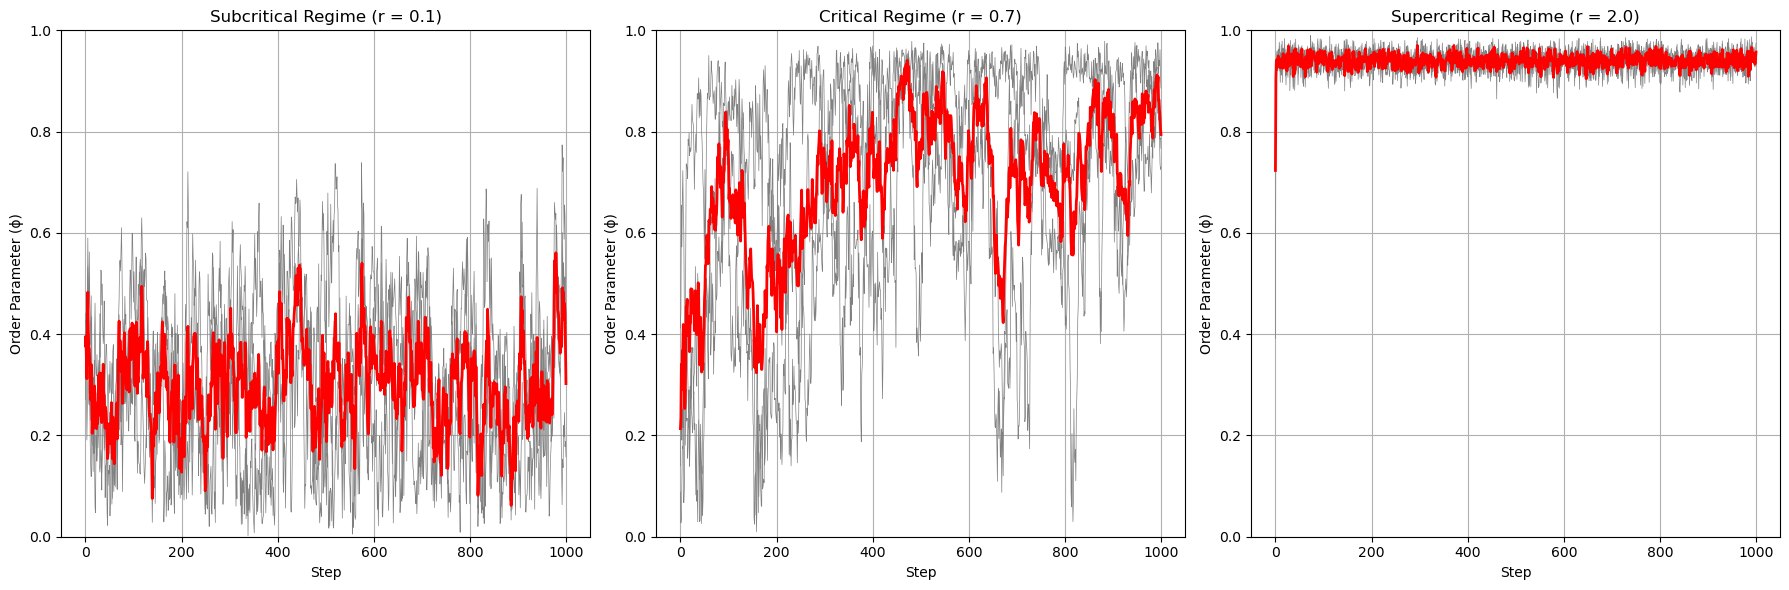

In [41]:
save_dir = "Data\\Vicsek_data"

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, (label, r) in enumerate(r_values.items()):
    all_order_params = []

    for k in range(n_simulations):
        # Format filename to 2 decimal places to match saved files
        filename = os.path.join(save_dir, f"angles_N{N}_r{r}_{k}.csv")

        df = pd.read_csv(filename)
        order_params = []

        for step in range(steps):
            row = df[df["step"] == step]
            angles = row.iloc[0, :N].to_numpy().astype(float)
            phi = compute_order_parameter(angles)
            order_params.append(phi)

        all_order_params.append(order_params)

        ax[i].plot(np.arange(len(order_params)), order_params, color='gray', linewidth=0.5, label=f"r = {r}")
        ax[i].set_xlabel("Step")
        ax[i].set_ylabel("Order Parameter (ϕ)")
        ax[i].set_title(f"{label} Regime (r = {r})")
        ax[i].set_ylim(0, 1)
        ax[i].grid(True)
    
    # Compute and plot average order parameter
    all_order_params = np.array(all_order_params)  # shape: (n_simulations, steps)
    mean_order = np.mean(all_order_params, axis=0)
    ax[i].plot(range(steps), mean_order, color='red', linewidth=2, label="Average")

plt.tight_layout()
plt.show()

# Artificial synergistic and redundant timeseries

Define functions

In [43]:
def generate_redundant_timeseries(n_features, n_samples, noise_factor=0.1):

    base_variable = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
    data = np.zeros((n_features, n_samples))
    
    for i in range(n_features):
        noise = np.random.normal(loc=0.0, scale=1.0, size=n_samples) * noise_factor
        data[i] = base_variable + noise
    
    return data

def generate_synergistic_timeseries(n_features, n_samples, noise_factor=0.1):

    data = np.zeros((n_features, n_samples))
    data[0] = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
    data[1] = np.random.normal(loc=0.0, scale=1.0, size=n_samples)

    for i in range(2, n_features):
        weights = np.random.uniform(-1, 1, size=i)
        combination = np.dot(weights, data[:i])
        noise = np.random.normal(loc=0.0, scale=1.0, size=n_samples) * noise_factor
        data[i] = combination + noise

    return data

Create redundant timeseries

In [44]:
n_simulations = 3
N_variables = 10
N_timesteps = 1000

for i in range(n_simulations):
    data_red = generate_redundant_timeseries(N_variables, N_timesteps)
    df = pd.DataFrame(data_red.T, columns=[f'feature_{i}' for i in range(N_variables)])
    df.to_csv(f'Data\\Artificial_data\\Redundant_timeseries\\timeseries_{i}.csv', index=False)

Create synergistic timeseries

In [45]:
n_simulations = 3
N_variables = 10
N_timesteps = 1000

for i in range(n_simulations):
    data_syn = generate_synergistic_timeseries(N_variables, N_timesteps)
    df = pd.DataFrame(data_syn.T, columns=[f'feature_{i}' for i in range(N_variables)])
    df.to_csv(f'Data\\Artificial_data\\Synergistic_timeseries\\timeseries_{i}.csv', index=False)